In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn import metrics 
%matplotlib inline

In [2]:
INPUT_SIGNAL_TYPES= [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
LABELS=[
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

In [3]:
DATASET_PATH="C:\\Users\\naveen chauhan\\Desktop\\mldata\\mlp\\Human Activity Recognition\\UCI HAR Dataset\\"
TRAIN="train\\"
TEST="test\\"
X_train_signal_path=[DATASET_PATH+TRAIN+"Inertial Signals\\"+signals+"train.txt" for signals in INPUT_SIGNAL_TYPES]
#print(X_train_signal_path)
X_test_signal_path=[DATASET_PATH+TEST+"Inertial Signals\\"+signals+"test.txt" for signals in INPUT_SIGNAL_TYPES]

def Load_X(X_signal_path):
    X_signals=[]
    for signal_type_path in X_signal_path:
        file=open(signal_type_path,'r')
        X_signals.append([np.array(serie,dtype=np.float32) for serie in [row.replace('  ',' ').strip().split() for row in file]])
        file.close()
    return np.transpose(X_signals,(1,2,0))

def Load_y(y_path):
    file=open(y_path,'r')
    y_=np.array([ele for ele in [row.replace('  ',' ').strip().split() for row in file]],dtype=np.int32)
    file.close()
    return y_-1
y_train_path=DATASET_PATH+TRAIN+"y_train.txt"
y_test_path=DATASET_PATH+TEST+"y_test.txt"

y_train=Load_y(y_train_path)
y_test=Load_y(y_test_path)

In [4]:
X_train = Load_X(X_train_signal_path)
X_test = Load_X(X_test_signal_path)

In [5]:
print(len(X_train))
print(len(X_test))
print(len(X_train[0]))
print(len(X_test[0][0]))
X_train.shape

7352
2947
128
9


(7352, 128, 9)

In [6]:
training_data_count=len(X_train)
test_data_count=len(X_test)
n_step=len(X_train[0]) #time step per series
n_input=len(X_train[0][0])

In [7]:
n_hidden=32
n_classes=6

learning_rate=0.0025
lambda_loss_amount=0.0015
training_iters=training_data_count*300
batch_size=1500
display_iter=30000

In [8]:
print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.0991399 0.395671
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [9]:
#now the utility_function for training
def LSTM_RNN(_X,_weights,_biases):
    #input shape  (batch_size.n_step,n_input)
    _X=tf.transpose(_X,[1,0,2])
    _X=tf.reshape(_X,[-1,n_input])
    #new shape (n_step*batch_size,n_inputs)
    _X=tf.nn.relu(tf.matmul(_X,_weights['hidden'])+_biases['hidden'])
    _X=tf.split(_X,n_step,0)
    lstm_cell_1=tf.contrib.rnn.BasicLSTMCell(n_hidden,forget_bias=1.0,state_is_tuple=True)
    lstm_cell_2=tf.contrib.rnn.BasicLSTMCell(n_hidden,forget_bias=1.0,state_is_tuple=True)
    lstm_cells=tf.contrib.rnn.MultiRNNCell([lstm_cell_1,lstm_cell_2],state_is_tuple=True)
    
    outputs,states=tf.contrib.rnn.static_rnn(lstm_cells,_X,dtype=tf.float32)
    lstm_last_output=outputs[-1]
    return tf.matmul(lstm_last_output,_weights['out'])+_biases['out']

#extract the batch size
def extract_batch_size(_train,step,batch_size):
    shape=list(_train.shape)
    shape[0]=batch_size
    batch_s=np.empty(shape)
    for i in range(batch_size):
        index=((step-1)*batch_size+i)%len(_train)
        batch_s[i]=_train[index]
    return batch_s

def one_hot(y_):
    y_=y_.reshape(len(y_))
    n_value=int(np.max(y_))+1
    return np.eye(n_value)[np.array(y_,dtype=np.int32)]

In [10]:
#now lets builds neural network
x=tf.placeholder(tf.float32,[None,n_step,n_input])
y=tf.placeholder(tf.float32,[None,n_classes])

weights={
    'hidden': tf.Variable(tf.random_normal([n_input,n_hidden])),
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases={
    'hidden':tf.Variable(tf.random_normal([n_hidden])),
    'out':tf.Variable(tf.random_normal([n_classes]))
}
pred=LSTM_RNN(x,weights,biases)

l2=lambda_loss_amount*sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
#l2 loss prevent this neural network to overfit the data
cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=pred))+l2
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred=tf.equal(tf.argmax(pred,1),tf.argmax(y,1))
accuracy=tf.reduce_mean(tf.cast(correct_pred,tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [13]:
#now train the neural network
test_losses=[]
test_accuracies=[]
train_losses=[]
train_accuracies=[]
sess=tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init=tf.global_variables_initializer()
sess.run(init)

step=1
while step*batch_size<=training_iters:
    batch_xs=extract_batch_size(X_train,step,batch_size)
    batch_ys=one_hot(extract_batch_size(y_train,step,batch_size))
    
    #fit training using batch data
    _,loss,acc=sess.run([optimizer,cost,accuracy],feed_dict={x:batch_xs,y:batch_ys})
    
    #evaluate training only at some stage of data
    if (step*batch_size%display_iter==0) or (step==1) or (step*batch_size>training_iters):
        print("training iter #" + str(step*batch_size) + ": Batch Loss = " + "{:.6f}".format(loss) + ",Accuracy={}".format(acc))
        loss,acc=sess.run([cost,accuracy],feed_dict={x:X_test,y:one_hot(y_test)})
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("performance on test set:"+"Batch loss ={}".format(loss)+"accuracy={}".format(acc))
    step+=1
print("optimization finished")

#accuracy on test dataset
one_hot_predictions,accuracy,final_loss=sess.run([pred,accuracy,cost],feed_dict={x:X_test,y:one_hot(y_test)})
test_losses.append(final_loss)
test_accuracies.append(accuracy)
print("final result "+"batch loss={}".format(final_loss)+"accuracy={}".format(accuracy))

C:\Users\naveen chauhan\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


training iter #1500: Batch Loss = 3.352726,Accuracy=0.16599999368190765
performance on test set:Batch loss =2.646357536315918accuracy=0.21479471027851105
training iter #30000: Batch Loss = 1.407829,Accuracy=0.6940000057220459
performance on test set:Batch loss =1.540776014328003accuracy=0.6620292067527771
training iter #60000: Batch Loss = 1.167025,Accuracy=0.7926666736602783
performance on test set:Batch loss =1.3780272006988525accuracy=0.7309128046035767
training iter #90000: Batch Loss = 0.997128,Accuracy=0.8820000290870667
performance on test set:Batch loss =1.2776381969451904accuracy=0.8001357316970825
training iter #120000: Batch Loss = 0.888102,Accuracy=0.9053333401679993
performance on test set:Batch loss =1.2203059196472168accuracy=0.8303359150886536
training iter #150000: Batch Loss = 0.777151,Accuracy=0.9419999718666077
performance on test set:Batch loss =1.164864182472229accuracy=0.8449270725250244
training iter #180000: Batch Loss = 0.912079,Accuracy=0.8726666569709778
per

training iter #1590000: Batch Loss = 0.373877,Accuracy=0.9453333616256714
performance on test set:Batch loss =0.6922156810760498accuracy=0.885646402835846
training iter #1620000: Batch Loss = 0.336633,Accuracy=0.9646666646003723
performance on test set:Batch loss =0.6942896842956543accuracy=0.8920936584472656
training iter #1650000: Batch Loss = 0.414174,Accuracy=0.9266666769981384
performance on test set:Batch loss =0.7246944904327393accuracy=0.8632507920265198
training iter #1680000: Batch Loss = 0.430735,Accuracy=0.9146666526794434
performance on test set:Batch loss =0.7196972370147705accuracy=0.8771632313728333
training iter #1710000: Batch Loss = 0.367598,Accuracy=0.9366666674613953
performance on test set:Batch loss =0.7166652083396912accuracy=0.8812351822853088
training iter #1740000: Batch Loss = 0.294716,Accuracy=0.9786666631698608
performance on test set:Batch loss =0.7150617837905884accuracy=0.8819137811660767
training iter #1770000: Batch Loss = 0.311630,Accuracy=0.97000002

C:\Users\naveen chauhan\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['BitStream Vera sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


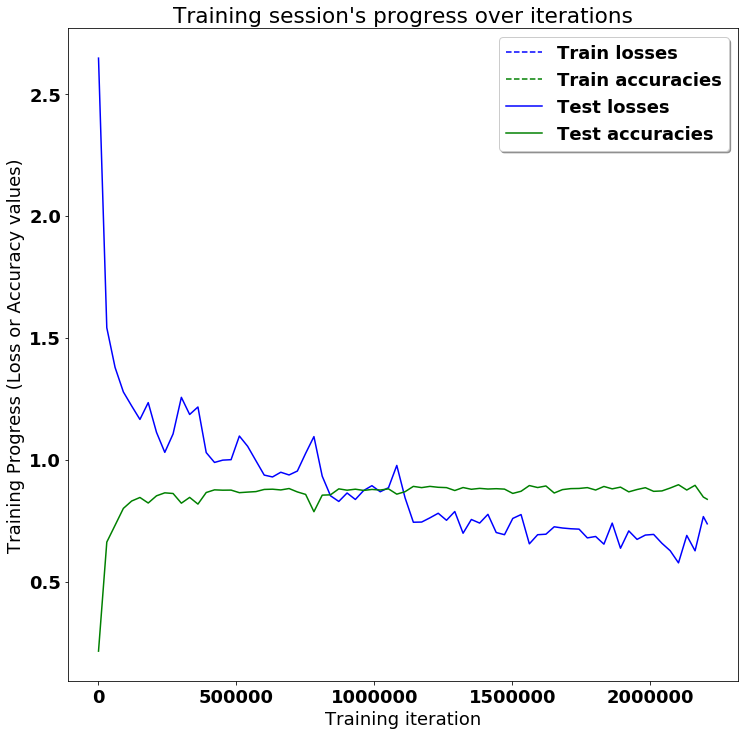

In [16]:
import matplotlib
%matplotlib inline 
font={
    'family':'BitStream Vera sans',
    'weight':'bold',
    'size':18
}

matplotlib.rc('font',**font)
width=12
height=12
plt.figure(figsize=(width,height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

Testing Accuracy: 83.74618291854858%

Precision: 84.42525326886326%
Recall: 83.7461825585341%
f1_score: 83.51630096499602%

Confusion Matrix:
[[477   5  12   0   2   0]
 [ 39 401  29   0   2   0]
 [ 70  77 273   0   0   0]
 [  0  25   0 340 126   0]
 [  0   2   0  63 467   0]
 [  0  27   0   0   0 510]]

C:\Users\naveen chauhan\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['BitStream Vera sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))




Confusion matrix (normalised to % of total test data):
[[ 16.18595123   0.16966406   0.40719375   0.           0.06786563   0.        ]
 [  1.32337964  13.60705757   0.98405153   0.           0.06786563   0.        ]
 [  2.37529683   2.61282659   9.26365757   0.           0.           0.        ]
 [  0.           0.84832031   0.          11.53715611   4.27553415   0.        ]
 [  0.           0.06786563   0.           2.13776708  15.84662342   0.        ]
 [  0.           0.91618598   0.           0.           0.          17.30573463]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


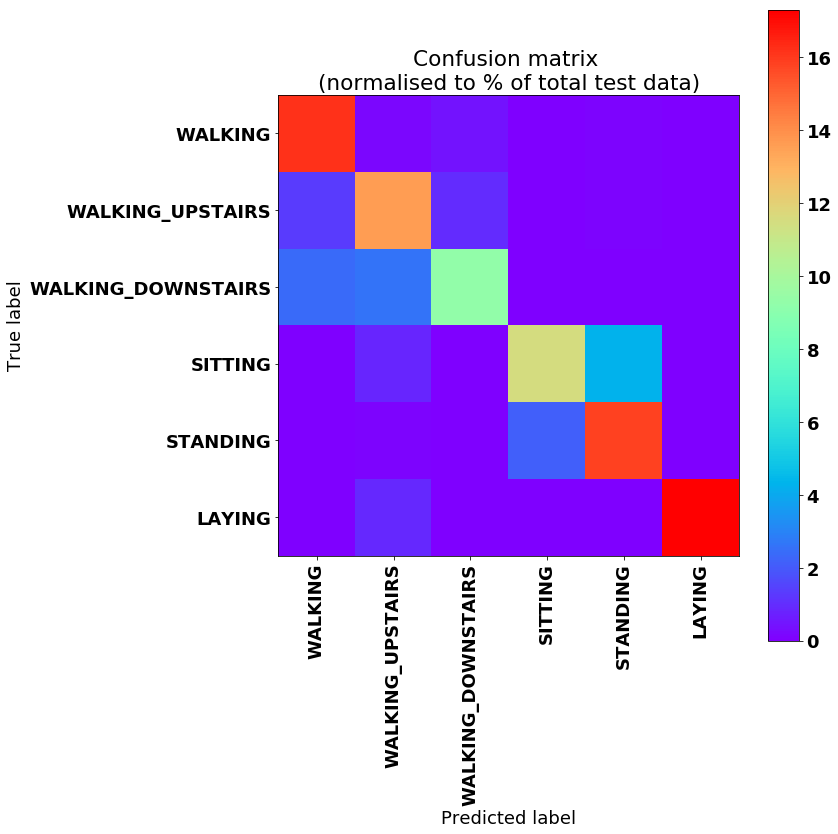

In [17]:
#multiclass classification matrix accuracy and confusion matrix
predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [18]:
sess.close()

In [19]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md

This application is used to convert notebook files (*.ipynb) to various other
formats.


Options

-------



Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.


--debug

    set log level to logging.DEBUG (maximize logging output)

--generate-config

    generate default config file

-y

    Answer yes to any questions instead of prompting.

--execute

    Execute the notebook prior to export.

--allow-errors

    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.

--stdin

    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'

--stdout

    Write notebook output to stdout instead of files.

--inplace

    Run nbconvert in 

[NbConvertApp] WARNING | pattern 'LSTM.ipynb' matched no files
'mv' is not recognized as an internal or external command,
operable program or batch file.
